# 1. Nhập dữ liệu

In [1]:
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors, MACCSkeys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.preprocessing as preprocessing

In [23]:
train_test_path = "../data_for_modeling/filter_data/v1/clean_data/HDAC2_train_test_unclean_data.xlsx"; 
train_dataset = pd.read_excel(train_test_path, sheet_name='train_dataset')
test_dataset = pd.read_excel(train_test_path, sheet_name='test_dataset')

In [44]:
print(len(train_dataset), len(test_dataset))

782 196


# 2. Xây dựng mô hình với MACCS

## 2.1. Mã hóa cấu trúc phân tử

In [24]:
def maccs_fpts(data):
    Maccs_fpts = []
    for i in data:
        mol = Chem.MolFromSmiles(i)
        fpts = MACCSkeys.GenMACCSKeys(mol)
        mfpts = np.array(fpts)
        Maccs_fpts.append(mfpts)
    return np.array(Maccs_fpts)

In [25]:
train_maccs_fpts = maccs_fpts(train_dataset['SMILES'])
test_maccs_fpts = maccs_fpts(test_dataset['SMILES'])
X_Train = train_maccs_fpts
X_Test = test_maccs_fpts

In [26]:
y_Train = np.array(train_dataset['ACTIVITY'])
y_Test = np.array(test_dataset['ACTIVITY'])

In [27]:
print(y_Train[0:5])
print(y_Test[0:5])

['Inactive' 'Inactive' 'Inactive' 'Active' 'Inactive']
['Inactive' 'Active' 'Inactive' 'Active' 'Inactive']


In [28]:
y_Train = preprocessing.LabelEncoder().fit_transform(y_Train)
y_Test = preprocessing.LabelEncoder().fit_transform(y_Test)

In [29]:
print(y_Train[0:5])
print(y_Test[0:5])

[1 1 1 0 1]
[1 0 1 0 1]


## 2.2. Xây dựng mô hình

__Random Forest Classifier__

In [30]:
from sklearn.ensemble import RandomForestClassifier
rf_maccs = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=0)
rf_maccs.fit(X_Train, y_Train)

RandomForestClassifier(criterion='entropy', random_state=0)

__K Nearest Neighbor__

In [31]:
from sklearn.neighbors import KNeighborsClassifier
knn_maccs = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
knn_maccs.fit(X_Train, y_Train)

KNeighborsClassifier()

__SVM__

In [32]:
from sklearn.svm import SVC
svm_maccs = SVC(kernel='rbf', probability=True, random_state=0)
svm_maccs.fit(X_Train, y_Train)

SVC(probability=True, random_state=0)

__XGBoost__

In [33]:
from xgboost import XGBClassifier
bst_maccs = XGBClassifier(n_estimators=100, objective='binary:logistic')
bst_maccs.fit(X_Train, y_Train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

## 2.3. Đánh giá và so sánh mô hình của tác giả

### 2.3.1. 10-fold-cross validation

In [34]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [35]:
X_Total = np.concatenate((X_Train, X_Test), axis=0)
y_Total = np.concatenate((y_Train, y_Test), axis=0)

__RF__

In [36]:
#KNN
cv = KFold(n_splits=10, random_state=1, shuffle=True)
knn_scores = cross_val_score(knn_maccs, X_Total, y_Total, scoring='accuracy', cv=cv, n_jobs=-1)
print('Độ chính xác của 10-fold cross validation KNN: %.3f (%.3f)' % (knn_scores.mean(), knn_scores.std()))

#Random forest
cv = KFold(n_splits=10, random_state=1, shuffle=True)
rf_scores = cross_val_score(rf_maccs, X_Total, y_Total, scoring='accuracy', cv=cv, n_jobs=-1)
print('Độ chính xác của 10-fold cross validation RF: %.3f (%.3f)' % (rf_scores.mean(), rf_scores.std()))

#SVM
cv = KFold(n_splits=10, random_state=1, shuffle=True)
svm_scores = cross_val_score(svm_maccs, X_Total, y_Total, scoring='accuracy', cv=cv, n_jobs=-1)
print('Độ chính xác của 10-fold cross validation SVM: %.3f (%.3f)' % (svm_scores.mean(), svm_scores.std()))

#xg_boost
cv = KFold(n_splits=10, random_state=1, shuffle=True)
bst_scores = cross_val_score(bst_maccs, X_Total, y_Total, scoring='accuracy', cv=cv, n_jobs=-1)
print('Độ chính xác của 10-fold cross validation XG_Boost: %.3f (%.3f)' % (bst_scores.mean(), bst_scores.std()))

Độ chính xác của 10-fold cross validation KNN: 0.771 (0.025)
Độ chính xác của 10-fold cross validation RF: 0.793 (0.032)
Độ chính xác của 10-fold cross validation SVM: 0.762 (0.036)
Độ chính xác của 10-fold cross validation XG_Boost: 0.788 (0.041)


### 2.3.2. Accuracy, Sensitivity, Specificity

In [37]:
from sklearn.metrics import confusion_matrix, accuracy_score
from tabulate import tabulate
import math

In [38]:
def model_evaluation_calculation(cm):
    tp = cm[0][0]; tn = cm[1][1]; fp = cm[0][1]; fn = cm[1][0]
    ac = (tp+tn)/(tp+tn+fp+fn)
    se = tp/(tp+fn)
    sp = tn/(tn+fp)
    mcc = (tp*tn - fp*fn) / math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    return ac, se, sp, mcc

In [39]:
def me_result(cm, model_name):
    cm_string = "Confusion matrix of " + model_name
    print(cm_string)
    print(cm)
    ac, se, sp, mcc = model_evaluation_calculation(cm)
    print("Comparision:")
    table = [[' ' 'AC', 'SE', 'SP', 'MCC'], [model_name, ac, se, sp, mcc]]
    print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

RF

In [40]:
#Random Forest
y_rf_pred = rf_maccs.predict(X_Test)
rf_cm = confusion_matrix(y_Test, y_rf_pred)
me_result(rf_cm, model_name="Random forest")

#KNN
y_knn_pred = knn_maccs.predict(X_Test)
knn_cm = confusion_matrix(y_Test, y_knn_pred)
me_result(knn_cm, model_name="KNN")

#SVM
y_svm_pred = svm_maccs.predict(X_Test)
svm_cm = confusion_matrix(y_Test, y_svm_pred)
me_result(svm_cm, model_name="SVM")

#XG Boost
y_bst_pred = bst_maccs.predict(X_Test)
bst_cm = confusion_matrix(y_Test, y_bst_pred)
me_result(bst_cm, model_name="XG Boost")

Confusion matrix of Random forest
[[78 13]
 [28 77]]
Comparision:
╒═══════════════╤══════════╤══════════╤══════════╤═════════╕
│               │       AC │       SE │       SP │     MCC │
╞═══════════════╪══════════╪══════════╪══════════╪═════════╡
│ Random forest │ 0.790816 │ 0.735849 │ 0.855556 │ 0.59094 │
╘═══════════════╧══════════╧══════════╧══════════╧═════════╛
Confusion matrix of KNN
[[71 20]
 [29 76]]
Comparision:
╒═════╤═══════╤══════╤══════════╤══════════╕
│     │    AC │   SE │       SP │      MCC │
╞═════╪═══════╪══════╪══════════╪══════════╡
│ KNN │  0.75 │ 0.71 │ 0.791667 │ 0.502847 │
╘═════╧═══════╧══════╧══════════╧══════════╛
Confusion matrix of SVM
[[69 22]
 [20 85]]
Comparision:
╒═════╤══════════╤══════════╤══════════╤══════════╕
│     │       AC │       SE │       SP │      MCC │
╞═════╪══════════╪══════════╪══════════╪══════════╡
│ SVM │ 0.785714 │ 0.775281 │ 0.794393 │ 0.568719 │
╘═════╧══════════╧══════════╧══════════╧══════════╛
Confusion matrix of XG Boost
[[7

### 2.3.3. AUC

In [41]:
from sklearn.metrics import RocCurveDisplay

In [42]:
from sklearn.metrics import roc_auc_score
knn_y_proba = knn_maccs.predict_proba(X_Test)[:, 1]
rf_y_proba = rf_maccs.predict_proba(X_Test)[:, 1]
svm_y_proba = svm_maccs.predict_proba(X_Test)[:, 1]
bst_y_proba = bst_maccs.predict_proba(X_Test)[:, 1]


knn_auc_score = roc_auc_score(y_Test, knn_y_proba)
rf_auc_score = roc_auc_score(y_Test, rf_y_proba)
svm_auc_score = roc_auc_score(y_Test, svm_y_proba)
bst_auc_score = roc_auc_score(y_Test, bst_y_proba)
print(knn_auc_score, rf_auc_score, svm_auc_score, bst_auc_score)

0.8332810047095761 0.8597069597069598 0.8405546834118263 0.8602302459445317


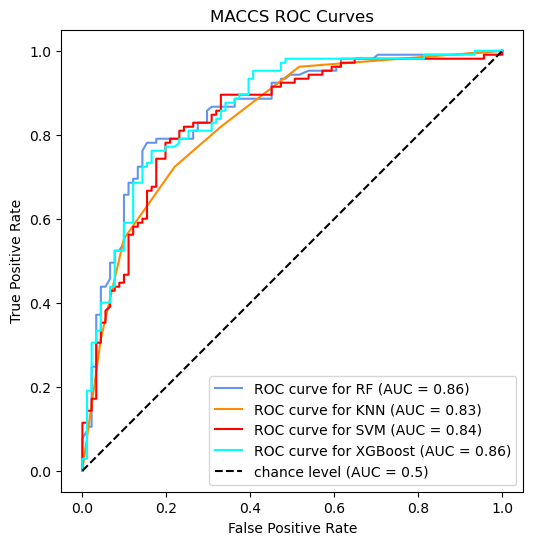

In [43]:
fig, ax = plt.subplots(figsize=(6, 6))

RocCurveDisplay.from_estimator(
    estimator=rf_maccs, 
    X=X_Test, 
    y=y_Test,
    name=f"ROC curve for RF",
    color='cornflowerblue',
    ax=ax)


RocCurveDisplay.from_estimator(
    estimator=knn_maccs, 
    X=X_Test, 
    y=y_Test,
    name=f"ROC curve for KNN",
    color='darkorange',
    ax=ax)

RocCurveDisplay.from_estimator(
    estimator=svm_maccs, 
    X=X_Test, 
    y=y_Test,
    name=f"ROC curve for SVM",
    color='red',
    ax=ax)

RocCurveDisplay.from_estimator(
    estimator=bst_maccs, 
    X=X_Test, 
    y=y_Test,
    name=f"ROC curve for XGBoost",
    color='aqua',
    ax=ax)

plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("MACCS ROC Curves")
plt.legend()
plt.show()